In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt

In [22]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')

In [23]:
# remove other ODA data
exclude_keywords = r"(?i)\baid\b|development assistance|ODA|primary income|official flows"
non_oda_data = og[~og['Indicator Name'].str.contains(exclude_keywords, na=False)]

target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

df_filtered = pd.concat([non_oda_data, target_oda_data])

df_filtered = df_filtered[df_filtered['Indicator Code'].isin(codes_to_keep)]

df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [24]:
df_filtered = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                        '2017', '2018', '2019', '2020', '2021']]
df_filtered = df_filtered[df_filtered.index >= 72281]

In [25]:
df_long = df_filtered.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

In [26]:
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]
df_pivot = df_pivot.sort_values(["Country Code", "Year"])

threshold = 0.5*len(df_pivot)
df_cleaned = df_pivot.dropna(axis = 1, thresh = threshold)
df = df_cleaned.copy()

In [27]:
df['target_lag1'] = df.groupby('Country Code')['Net official development assistance received (constant 2021 US$)'].shift(1)
df = df.dropna(subset=['target_lag1'])
df['Year'] = df['Year'].astype(int)

df.to_csv('pivot_lagged_clean.csv', index=False)


In [28]:

# separate features from target 
y = np.arcsinh(df['target_lag1']) # transform because of skew
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'target_lag1', 'Country Name', 'Country Code', 'Year'])

# Handle missing values (same as before)
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split
cutoff = 2017
train_mask = df['Year'] <= cutoff
test_mask = df['Year'] > cutoff

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# Scale features (optional for Random Forest, but can help with interpretation)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_30943/2355765947.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_30943/2355765947.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_30943/2355765947.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Train RMSE: 2.5868
Test RMSE: 4.0420
Train R²: 0.7568
Test R²: 0.5310


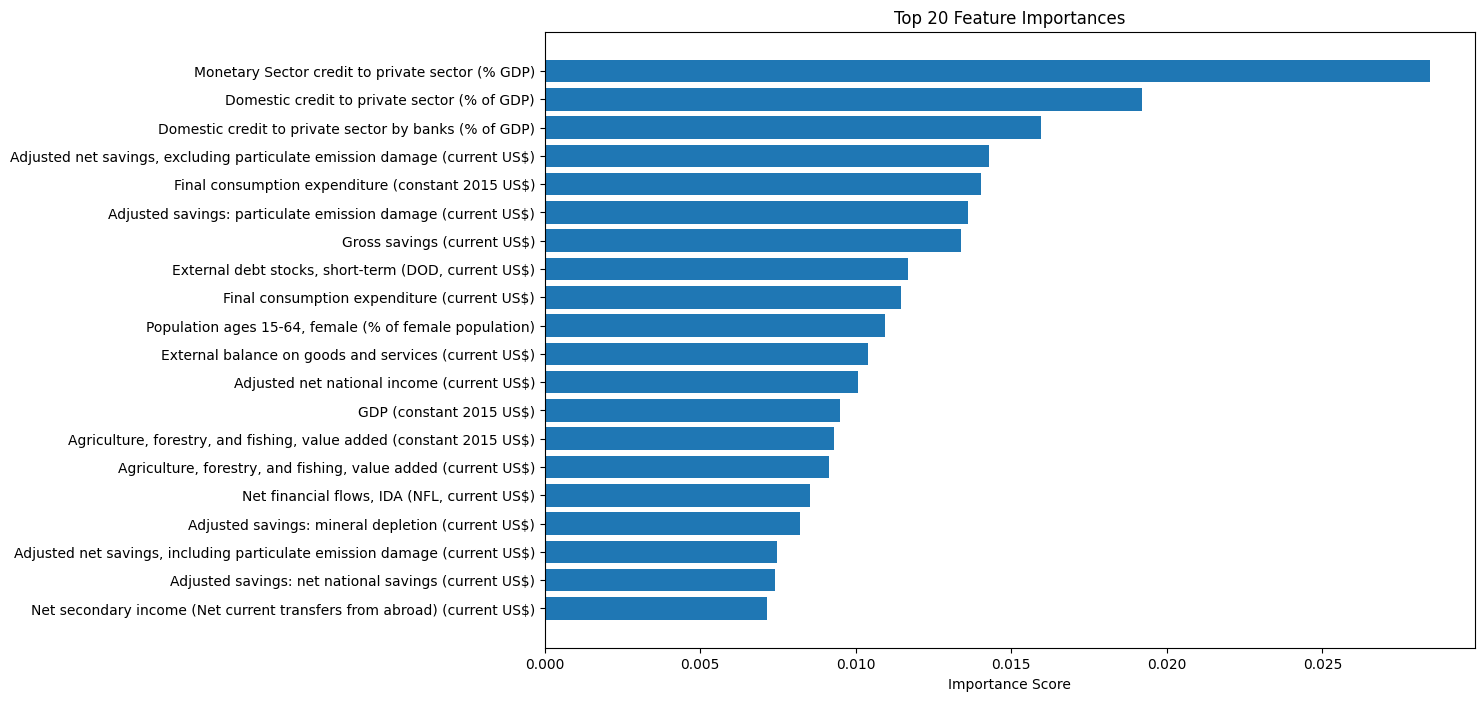

In [29]:

## Random Forest Implementation

# Initialize with reasonable defaults
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
rf.fit(X_train_scaled, y_train)

# Make predictions
train_pred = rf.predict(X_train_scaled)
test_pred = rf.predict(X_test_scaled)

# Evaluate
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")
print(f"Train R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, test_pred):.4f}")

## Feature Importance Visualization
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()